In [95]:
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [96]:
# 配置日志
import logging
import logging.config
import yaml

with open('.conf/logging.yml', 'r') as f_conf:
    dict_conf = yaml.safe_load(f_conf)
logging.config.dictConfig(dict_conf)


In [97]:
# 清除原始日志
import shutil
import os

dir_path = './logs/'
shutil.rmtree(dir_path, ignore_errors=True)
os.mkdir(dir_path)
os.mknod(dir_path + '/all.log')


In [98]:
# 读取轨迹数据
from utils.load import *

# 读取标记数据，单个轨迹
df_label = pd.read_json("dataset/GTMarker/001/markerRaw/g2/g2-1-2.json")
df_label = df_label[df_label.trackID == 6]

# 读取原始轨迹
dataset_path = 'dataset/Geolife Trajectories 1.3/Data/001/'
dataset = enumerate(LoadG(dataset_path, 2))
dfs = pd.DataFrame()
for i, df in dataset:
    df['trackID'] = i + 1
    dfs = pd.concat([dfs, df], ignore_index=True)
dfs.reset_index(drop=True)
pass


In [36]:
# tmp = pieces
# for p in tmp:
#     print(p, p[1]-p[0]+1)
#     p = dpc.df.loc[p[0]:p[1]]
#     p = p.rawIndex.tolist()
#     print(p[0], p[-1], len(p))


[358, 413] 56
8897 8952 56
[0, 24] 25
8539 8563 25
[63, 97] 35
8602 8636 35
[156, 157] 2
8695 8696 2
[311, 357] 47
8850 8896 47
[26, 61] 36
8565 8600 36


<AxesSubplot:xlabel='lng', ylabel='lat'>

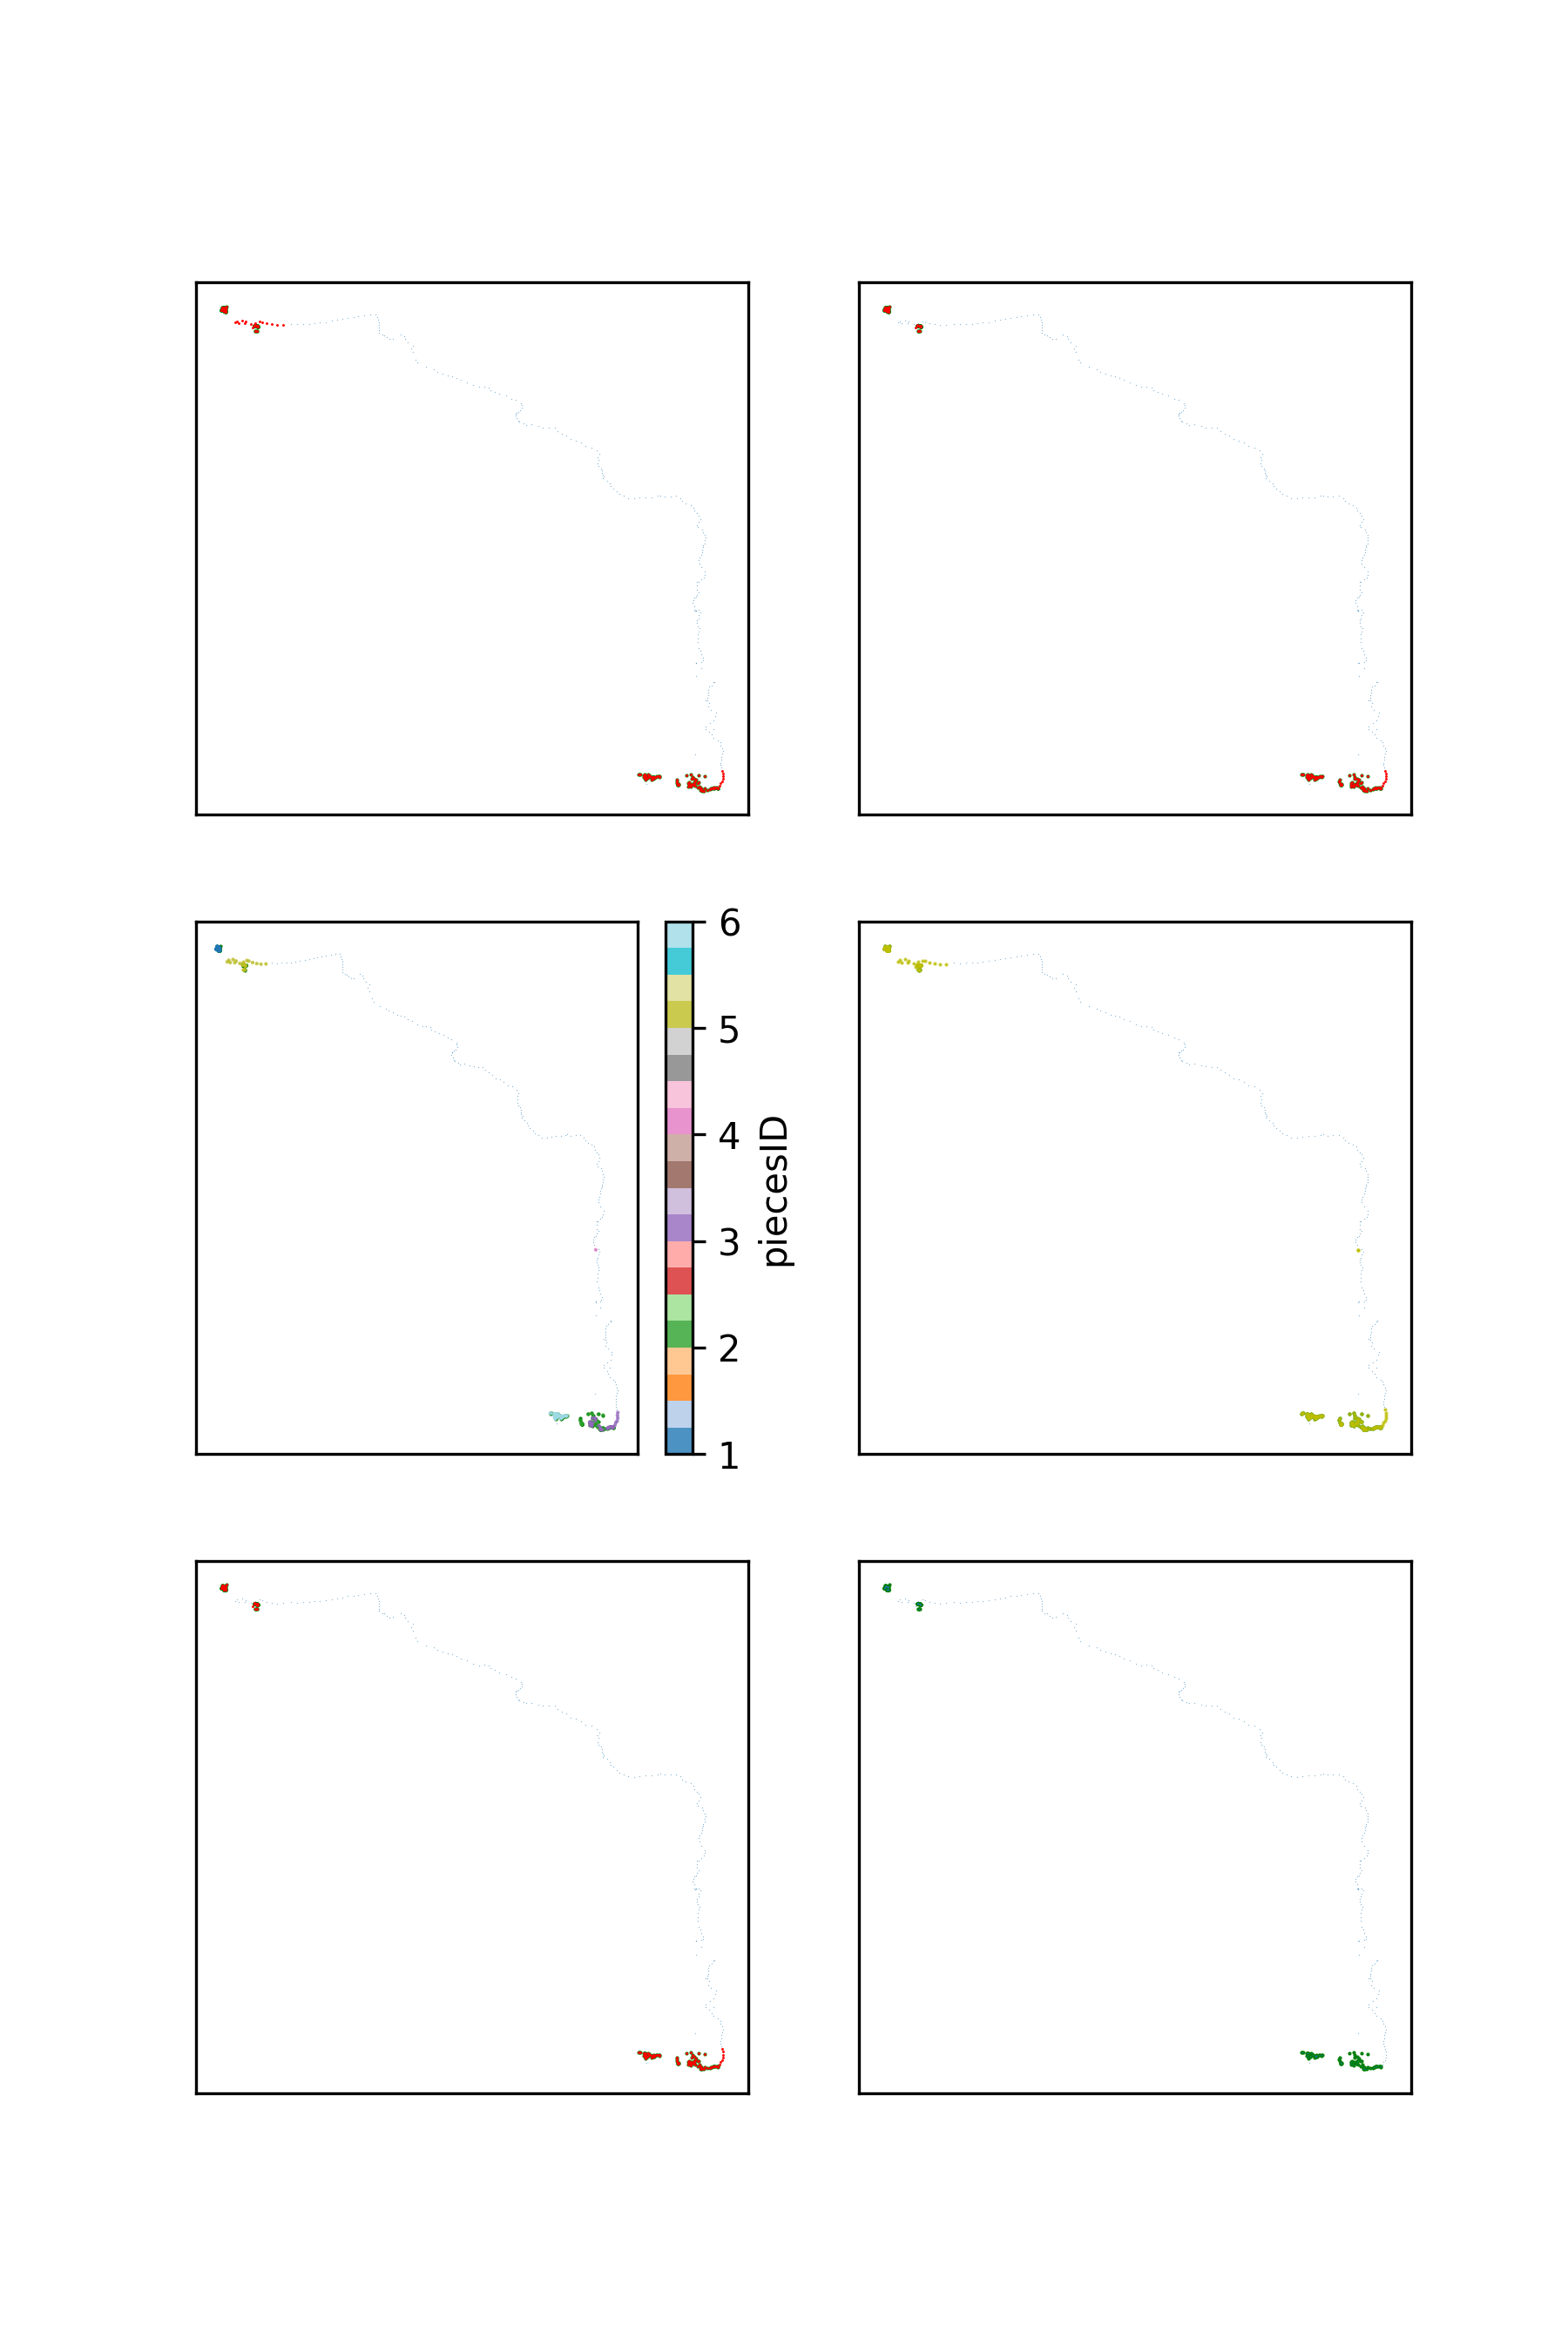

In [99]:
from utils.inspection import EvalCluster, Evaluation
from dpc.dpc_link import DPCLink
from dpc.dpc_link_te import *
from dpc.dpc_link_te import DPCLink_TE as DPCLTE
import matplotlib.pyplot as plt
%matplotlib widget

# 一次提取
dpc = DPCLTE(dfs[dfs.trackID == 6])
dpc.calDis()
dpc.calDc(p=0.02)
dpc.calRho()
dpc.calDel()
dpc.calGam()
dpc.getCen(4)
dpc.cluster(1)
pieces = dpc.tempory()
df_prediciton1 = dpc.entropy(pieces).copy(deep=True)


# 可视化
fig, axes = plt.subplots(3, 2, figsize=(6, 9), dpi=300)
axes = axes.ravel()
for ax in axes:
    df_label[df_label.type == 'activity'].plot.scatter(x='lng', y='lat', c='g', s=1, ax=ax, linewidths=0)  # 标记的驻足点
    dpc.df.plot.scatter(x='lng', y='lat', s=0.1, alpha=0.5, linewidths=0, ax=ax)  # 原始轨迹
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

# 二次提取
df_prediciton2 = pd.DataFrame()
pieces2_all = []
# i=4
for pie in pieces[:]:
    tmp = dpc.df.loc[pie[0]:pie[1]]
    try:
        dpc2 = DPCLTE(tmp)
    except AssertionError:
        pass
    dpc2.calDis()
    dpc2.calDc(p=0.2)
    dpc2.calRho()
    dpc2.calDel()
    dpc2.calGam()
    dpc2.getCen(1)
    dpc2.cluster(1)

    dpc2.df.plot.scatter(x='lng', y='lat',  c='y', s=1, alpha=0.8, linewidths=0, ax=axes[3])

    pieces2 = tempory(dpc2.df)

    # dpc2.df[dpc2.df.piecesID != -1].plot.scatter(x='lng', y='lat',  c='piecesID', colormap='tab20', s=1, alpha=0.8, linewidths=0, ax=axes[5])  # 切片结果
    # print(dpc2.df)
    # tmp = pieces2[0]
    # tmp = dpc2.df.loc[tmp]
    # pieces2_all = pieces2_all+pieces2

    tmp = dpc2.entropy(pieces2, thresholdEI=1.3)

    dpc2.df[dpc2.df.type == 'activity'].plot.scatter(x='lng', y='lat', c='r', s=0.5, ax=axes[1], linewidths=0)  # 二次提取的驻足点
    # 轨迹点信息显示
    # for p in df_prediciton2.loc[8602:8635].itertuples():
    #     # msg = f'{p.Index}\n{p.rho:.2f}\n{p.datetime}'
    #     msg = f'{p.Index}\n{p.rho:.2f}'
    #     # axes[2].text(p.lng, p.lat, s=msg, fontsize=1)

    df_prediciton2 = pd.concat([df_prediciton2, tmp])

for i, pie in enumerate(pieces):
    dpc.df.loc[p[0]:p[1]].rawIndex.tolist()

df_prediciton1[df_prediciton1.piecesID != -1].plot.scatter(x='lng', y='lat',  c='piecesID', colormap='tab20', s=1, alpha=0.8, linewidths=0, ax=axes[2])  # 切片结果
df_prediciton1[df_prediciton1.type == 'activity'].plot.scatter(x='lng', y='lat', c='r', s=0.5, ax=axes[0], linewidths=0)  # 一次提取的驻足点
df_prediciton2[df_prediciton2.type == 'activity'].plot.scatter(x='lng', y='lat', c='r', s=0.5, ax=axes[4], linewidths=0)  # 二次提取的驻足点

# dpc.df.plot.scatter(x='lng', y='lat', c='clusterID', colormap='tab20', s=1, alpha=0.8, linewidths=0, ax=axes[4])  # 聚类结果
# dpc.df.iloc[dpc.centers].plot.scatter(x='lng', y='lat', c='g', s=2, ax=ax, linewidths=0) # 聚类中心点


# 单点查看
# p = dpc.df.iloc[6382]
# ax.scatter(p.lng, p.lat, c='red', s=0.1)


In [100]:

tmp = df_prediciton1.copy(deep=True)
tmp.set_index('rawIndex', inplace=True)
tmp.type = ''
indexs = df_prediciton2[df_prediciton2.type == 'activity'].rawIndex.to_list()
tmp.loc[indexs, 'type'] = 'activity'
df_prediciton2 = tmp


{'accuracy': [0.9444444444444444], 'precision': [0.8844221105527639], 'recall': [1.0], 'findex': [0.9386666666666666]}
{'accuracy': [0.9782608695652174], 'precision': [0.9513513513513514], 'recall': [1.0], 'findex': [0.9750692520775623]}


<AxesSubplot:xlabel='lng', ylabel='lat'>

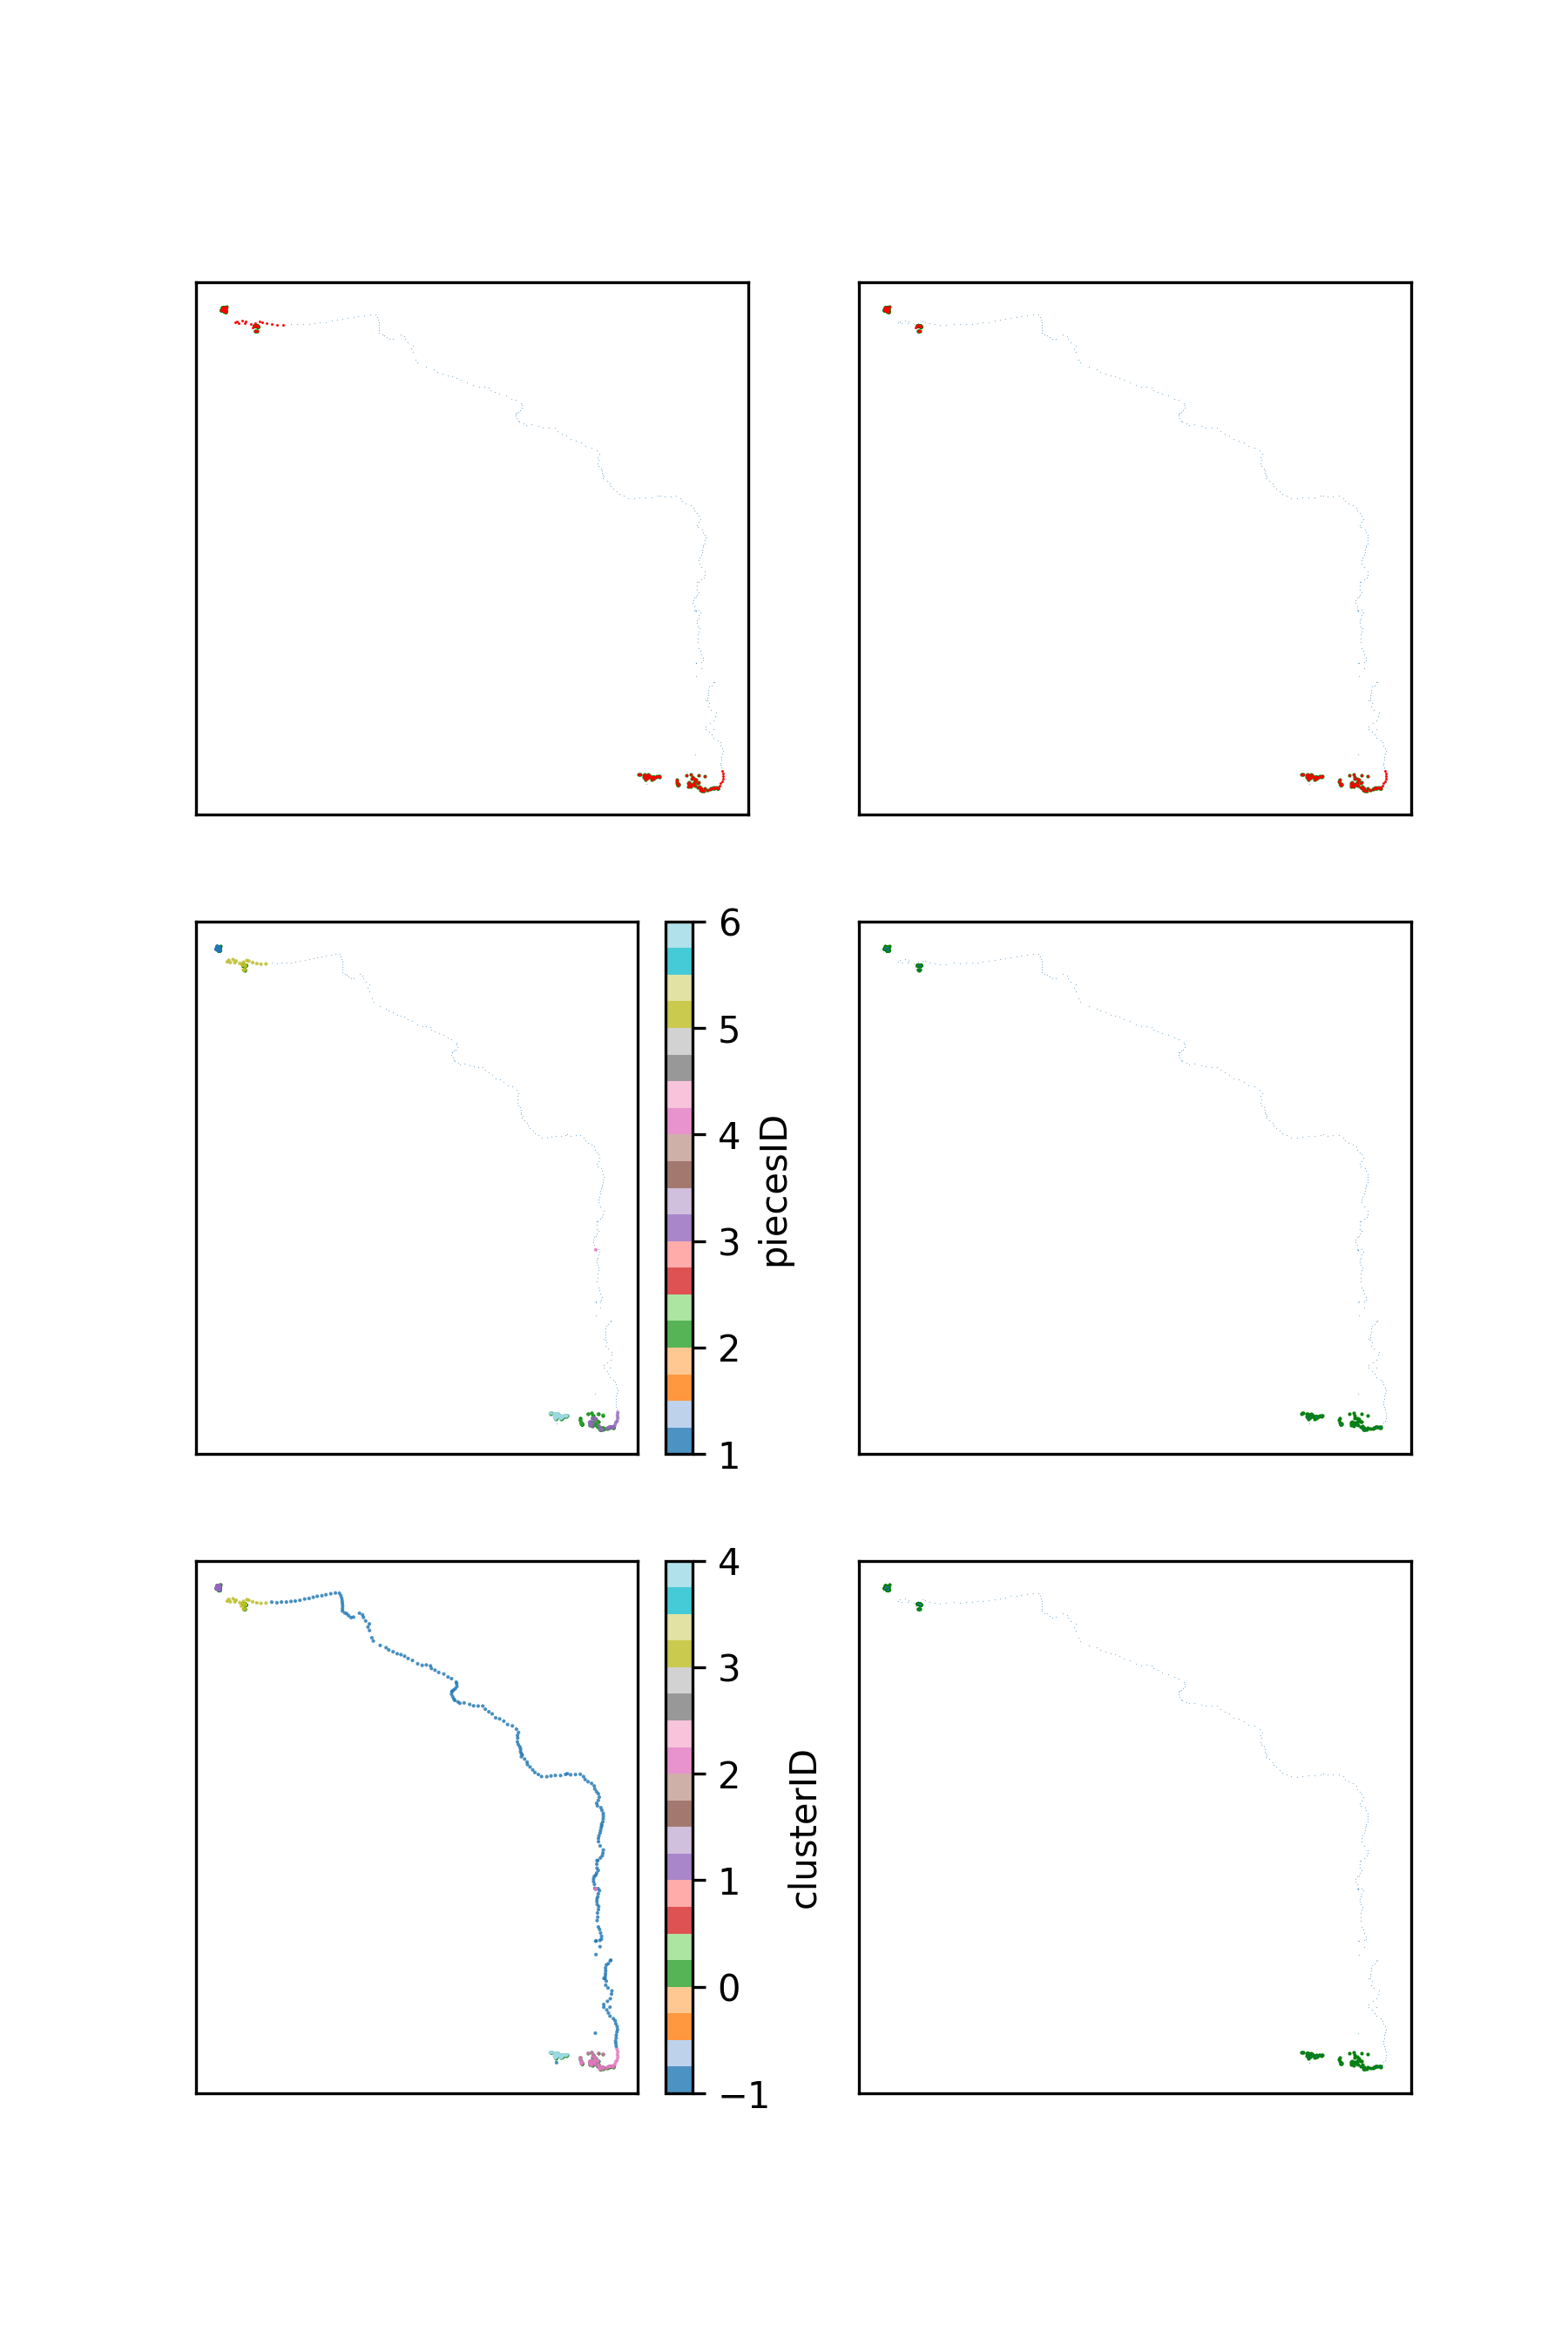

In [101]:

# 聚类结果分析
eval = Evaluation(df_label, df_label)
df_prediciton1.set_index('rawIndex', drop=True, inplace=True)
# df_prediciton2.set_index('rawIndex', drop=True, inplace=True)
eval.setDfp(df_prediciton1)
analysis = {'accuracy': [], 'precision': [], 'recall': [], 'findex': []}
analysis['accuracy'].append(eval.Acc())
analysis['precision'].append(eval.Precision())
analysis['recall'].append(eval.Recall())
analysis['findex'].append(eval.FI())
print(analysis)
eval.setDfp(df_prediciton2)
analysis = {'accuracy': [], 'precision': [], 'recall': [], 'findex': []}
analysis['accuracy'].append(eval.Acc())
analysis['precision'].append(eval.Precision())
analysis['recall'].append(eval.Recall())
analysis['findex'].append(eval.FI())
print(analysis)

# 可视化
fig, axes = plt.subplots(3, 2, figsize=(6, 9), dpi=300)
axes = axes.ravel()
for ax in axes:
    df_label[df_label.type == 'activity'].plot.scatter(x='lng', y='lat', c='g', s=1, ax=ax, linewidths=0)  # 标记的驻足点
    dpc.df.plot.scatter(x='lng', y='lat', s=0.1, alpha=0.5, linewidths=0, ax=ax)  # 原始轨迹
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

# 轨迹点信息显示
for p in df_prediciton2.loc[8602:8635].itertuples():
    # msg = f'{p.Index}\n{p.rho:.2f}\n{p.datetime}'
    msg = f'{p.Index}\n{p.rho:.2f}'
    # axes[2].text(p.lng, p.lat, s=msg, fontsize=1)

for i, pie in enumerate(pieces):
    dpc.df.loc[p[0]:p[1]].rawIndex.tolist()

df_prediciton1[df_prediciton1.piecesID != -1].plot.scatter(x='lng', y='lat',  c='piecesID', colormap='tab20', s=1, alpha=0.8, linewidths=0, ax=axes[2])  # 切片结果
df_prediciton1[df_prediciton1.type == 'activity'].plot.scatter(x='lng', y='lat', c='r', s=0.5, ax=axes[0], linewidths=0)  # 一次提取的驻足点
df_prediciton2[df_prediciton2.type == 'activity'].plot.scatter(x='lng', y='lat', c='r', s=0.5, ax=axes[1], linewidths=0)  # 二次提取的驻足点

dpc.df.plot.scatter(x='lng', y='lat', c='clusterID', colormap='tab20', s=1, alpha=0.8, linewidths=0, ax=axes[4])  # 聚类结果
# dpc.df.iloc[dpc.centers].plot.scatter(x='lng', y='lat', c='g', s=2, ax=ax, linewidths=0) # 聚类中心点


# 单点查看
# p = dpc.df.iloc[6382]
# ax.scatter(p.lng, p.lat, c='red', s=0.1)


In [47]:
from utils.inspection import EvalCluster, Evaluation
x = {'groups': []}
analysis = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'findex': []
}

eval = Evaluation(df_label, df_label)
for arg in np.arange(2, 40, 2):
    eval.setDfp(dpc.TE(thresholdEI=2.1, groups=arg))

    x['groups'].append(arg)
    try:
        analysis['accuracy'].append(eval.Acc())
    except:
        analysis['accuracy'].append(-1)
    try:
        analysis['precision'].append(eval.Precision())
    except:
        analysis['precision'].append(-1)
    try:
        analysis['recall'].append(eval.Recall())
    except:
        analysis['recall'].append(-1)
    try:
        analysis['findex'].append(eval.FI())
    except:
        analysis['findex'].append(-1)

    # analysis['precision'].append(eval.Precision())
    # analysis['recall'].append(eval.Recall())
    # analysis['findex'].append(eval.FI())

    # msg = f'minRho: {minRho:.2}, precision: {eval.Precision():2.2%}, recall: {eval.Recall():2.2%}'
    # print(msg)


In [27]:
# 计算每个点的ei
from utils.indexs import entroyIndex
from utils.itertool import *
dfs['ei'] = None
for trackID, df in dfs.groupby('trackID'):
    for pie, i in EIPieces(df.index.to_list(), 6):
        df_pie = dfs.loc[pie]
        thetas = [t for t in Df2T(df_pie)]
        ei = entroyIndex(thetas, 8)
        dfs.loc[i, 'ei'] = ei


In [ ]:
# 测试轨迹ei正确性
from utils.indexs import _ei
from utils.itertool import *
import matplotlib.pyplot as plt
%matplotlib widget


fig, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=500)
# for ax in axes:
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
# ax[0, 0].set_autoscaley_on(True)
# lines, = ax.plot([], [])


configs = {
    'move': ['.', 'c'],
    'slow': ['.', 'c'],
    'tempory': ['.', 'c'],
    'activity': ['+', 'r']
}
df_track = dfs[dfs.trackID == 2]
# for p in df_track.itertuples():
#     ax.scatter(p.lng, p.lat, s=1, c='c', marker=configs[p.type][0], edgecolors='none')
#     msg = f'{i}{typeP}{ei}'


for pie, i in EIPieces(df_track.index.tolist(), 2):
    p = dfs.loc[i]
    # ax.scatter(p.lng, p.lat, s=2, c=configs[p.type][1], marker=configs[p.type][0])
    ax.scatter(p.lng, p.lat, s=2, c='c')

    thetas = dfs.loc[pie]
    thetas = [t for t in Df2T(thetas)]
    ei = _ei(thetas, 10)
    msg = f'{i}, {ei}\n{pie}'
    ax.text(p.lng, p.lat, s=msg, fontsize=1)

    # df_track.plot.scatter(x='lng', y='lat', s=2, alpha=0.1, linewidth=0, ax=ax)
    # df_track.loc[pieces].plot.scatter(x='lng', y='lat', s=2, alpha=0.4, c='g', linewidth=0, ax=ax)
    # plt.show()
    pass

# pieces=EIPieces(df_track.index.tolist(), 3)
pass


219 move 1.0114042647073518


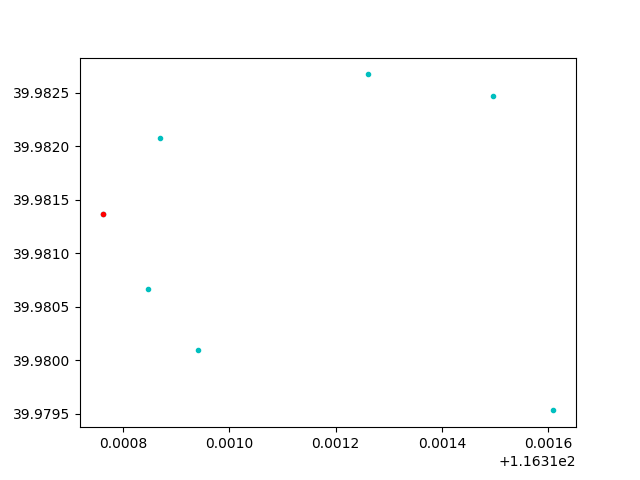

In [282]:
plt.clf()
pie, i = next(pieces)
for p in df_label.loc[pie].itertuples():
    plt.scatter(p.lng, p.lat, marker=configs[p.type][0], c='c')
plt.scatter(df_label.loc[i, 'lng'], df_label.loc[i, 'lat'], marker=configs[df_label.loc[i, 'type']][0], c='r')
# dfs.loc[pie].plot.scatter(x='lng', y='lat')
typeP = df_label.loc[i, 'type']
thetas = dfs.loc[pie]
thetas = [t for t in Df2T(thetas)]
ei = _ei(thetas, 8)
print(i, typeP, ei)
plt.show()


In [7]:
import matplotlib.pyplot as plt
%matplotlib widget
plt.boxplot(list(analysis.values()), labels=list(analysis.keys()), vert=True)
pass


NameError: name 'analysis' is not defined

In [33]:
eval.setDfp(dpc.TE())
msg = f'precision: {eval.Precision():2.2%}, recall: {eval.Recall():2.2%}'
print(msg)


precision: 26.20%, recall: 99.86%


In [43]:
x['eithreshold'][analysis['accuracy'].index(max(analysis['accuracy']))]


2.1

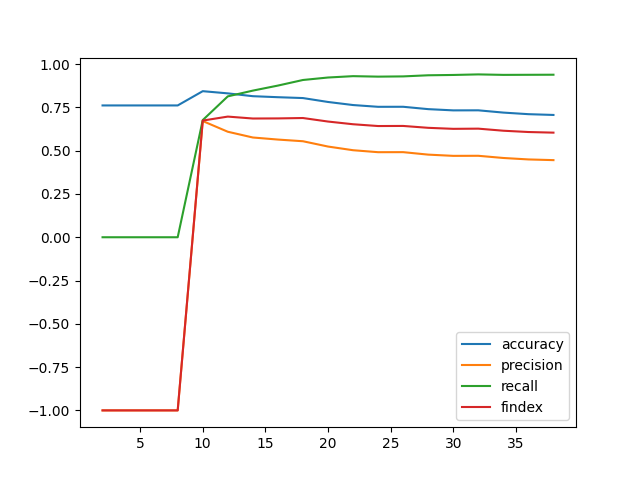

In [48]:
from utils.drawing import pltxys
%matplotlib widget
pltxys(x, analysis)


In [40]:
x = {'minRhos': []}
ys = {
    'postiveProps': [],
    'negativeProps': []
}
for minRho in np.arange(0, 10, 0.5):
    dpc.cluster(minRho)
    postiveProp, negaiveProp = preCluster(dpc.df, dfl)

    x['minRhos'].append(minRho)
    ys['postiveProps'].append(postiveProp)
    ys['negativeProps'].append(negaiveProp)


KeyboardInterrupt: 

In [44]:
x = []
analysis = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'findex': []
}
eval = Evaluation(dfl, dfl)
for minRho in np.arange(0, 10, 0.1):
    dpc.getCen(30)
    dpc.cluster(minRho)
    eval.setDfp(dpc.TE())

    x.append(minRho)
    analysis['accuracy'].append(eval.Acc())
    analysis['precision'].append(eval.Precision())
    analysis['recall'].append(eval.Recall())
    analysis['findex'].append(eval.FI())

    # msg = f'minRho: {minRho:.2}, precision: {eval.Precision():2.2%}, recall: {eval.Recall():2.2%}'
    # print(msg)


dpc.DPCL_TE      INFO     30 center points: [1288 4969 4738 1059  533 6704 3810 5286 5498 7544 3517 5249  850 9042
 5635 6882 7711 7826 5003  699 8504 5045 2559 6186  575 4101 6243 5030
 5989  756]
dpc.DPCL_TE      INFO     30 center points: [1288 4969 4738 1059  533 6704 3810 5286 5498 7544 3517 5249  850 9042
 5635 6882 7711 7826 5003  699 8504 5045 2559 6186  575 4101 6243 5030
 5989  756]
dpc.DPCL_TE      INFO     30 center points: [1288 4969 4738 1059  533 6704 3810 5286 5498 7544 3517 5249  850 9042
 5635 6882 7711 7826 5003  699 8504 5045 2559 6186  575 4101 6243 5030
 5989  756]
dpc.DPCL_TE      INFO     30 center points: [1288 4969 4738 1059  533 6704 3810 5286 5498 7544 3517 5249  850 9042
 5635 6882 7711 7826 5003  699 8504 5045 2559 6186  575 4101 6243 5030
 5989  756]
dpc.DPCL_TE      INFO     30 center points: [1288 4969 4738 1059  533 6704 3810 5286 5498 7544 3517 5249  850 9042
 5635 6882 7711 7826 5003  699 8504 5045 2559 6186  575 4101 6243 5030
 5989  756]
dpc.DPCL_T

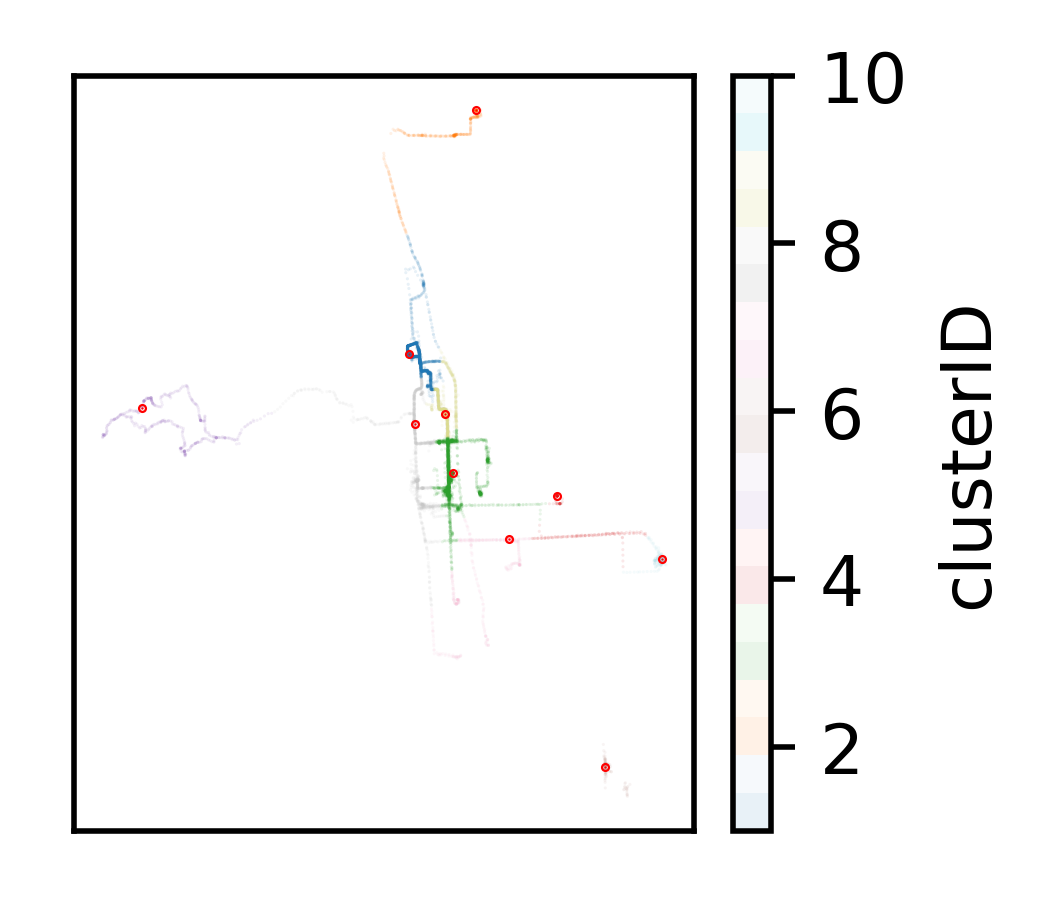

In [6]:
fig, ax = plt.subplots(figsize=(2, 2), dpi=500)
dpc.df.plot.scatter(x='lng', y='lat', c='clusterID', colormap='tab20', s=0.2, alpha=0.1, linewidths=0, ax=ax)
# dfs.plot.scatter(x='lng', y='lat', s=0.1, alpha=0.1, linewidths=0, ax=ax)
dpc.df.iloc[dpc.centers].plot.scatter(x='lng', y='lat', c='red', s=0.1, ax=ax)
# p = dpc.df.iloc[6382]
# ax.scatter(p.lng, p.lat, c='red', s=0.1)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

m = folium.Map(location=[39.984094, 116.319236], zoom_start=16)
ls = []
dataset = enumerate(itertools.islice(LoadG(dataset_path), 0, 50))
for i, df in dataset:
    l = [[lat, lng]for [lat, lng, *_] in df.values]
    folium.PolyLine(l, weight=0.4).add_to(m)
    ls.extend(l)
HeatMap(ls).add_to(m)

for p in dpc.centers:
    folium.Marker([dpc.df.loc[p, 'lat'], dpc.df.loc[p, 'lng']]).add_to(m)
m.save('map/df.html')


In [ ]:
# 距离矩阵检查
from dpc.dpc_link_te import DPCLink_TE
import matplotlib.pyplot as plt
%matplotlib widget


tmp = dpc.df.loc[8850:8862]
dpc_tmp = DPCLink_TE(tmp)
dpc_tmp.calDis()
df_tmp = dpc_tmp.df

fig, ax = plt.subplots(figsize=(3, 3), dpi=300)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

df_tmp.plot.scatter(x='lng', y='lat', s=10, alpha=1, linewidths=0, ax=ax)
for i, *_ in df_tmp[:df_tmp.shape[0] - 1].itertuples():
    for j, *_ in df_tmp[i + 1:df_tmp.shape[0]].itertuples():
        print(i, j)
        ax.arrow(df_tmp.loc[i, 'lng'],
                 df_tmp.loc[i, 'lat'],
                 df_tmp.loc[j, 'lng']-df_tmp.loc[i, 'lng'],
                 df_tmp.loc[j, 'lat']-df_tmp.loc[i, 'lat'],
                 width=0.0,
                 head_width=0.00,
                 alpha=0.1,
                 linestyle='-')
        ax.text(df_tmp.loc[j, 'lng']+0.00001, df_tmp.loc[j, 'lat']+0.00001, s=dpc_tmp.dis[0,j], fontsize=5)
    break

# 轨迹点信息显示
for p in df_tmp.itertuples():
    msg = f'{p.Index}'
    # msg = f'{p.rawIndex}'
    ax.text(p.lng, p.lat, s=msg, fontsize=5)
